# Epidemic model

See the associated pdf file for detailed explanations

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import rand
from matplotlib import colors
import random
from random import choices
import os
from tqdm import tqdm

#### Creat regular grid (nxm) graph that can support any number of distinct communitites

In [2]:
def create_graph_nm(n, m, num_communities=1):
    """Create <num_communities> regular grid graphs as num_communities communities within a single network

    Args:
        n (int): Length of grid
        m (int): Width of grid. Number of nodes in each community is n*m
        num_communities (int): Number of communities

    Returns:
        G (graph): Graph of <num_communities> different regular grid graphs of size nxn
    """
    # Initialize the graph based on communities
    G = nx.Graph()
    
    # Store graph for each seperate community
    Gs = []
    
    # Generate each community
    for i in range(num_communities):
        g = nx.grid_2d_graph(n, m, periodic=True)   # Periodic bouundary conditions, mitigate edge evects of small graphs

        # Map node labels to higher number to prevent clash with previous communities
        mapping = {(a,b):(a+n*i,b) for a in range(n) for b in range(m)}
        g = nx.relabel_nodes(g, mapping)

        Gs.append(g)
        
    # Add each community seperately into graph
    for i, g in enumerate(Gs):
        G.add_edges_from(g.edges(), community=i)
    
    return G

In [3]:
def repeated_sampling(list, size):
    """Repeatedly sample <size> elements from list randomly without repitition
       Ex: repeated_sampling([1,2,3,4,5,6,7,8,9,10], 3) might return [[5, 8, 2], [6, 3, 1], [7, 10, 9], [4]]
       This is used later to randomly select nodes (without replacement) for several simulation runs each 
       day of simulation
    """
    
    # Randomly shuffle list, so partitions will be random samples without replacement
    random.shuffle(list)    # random.shuffle occurs in place
    sample = [list[i:i+size] for i in range(0, len(list), size)]
    
    return sample

### Function to simulate migration between two nodes in different communities

In [4]:
def migration_nm(G, n, m, num_communities):
    """For a graph G randomly select two vertices from two different random communities
    and swap the sates of the two nodes

    Args:
        G (Graph): networkx graph containing <num_communities> * n**2 nodes
        n (int): 
        m (int): n*m nodes each community
        num_communities (int): Number of communities (disjoint n*n grids) in graph

    Returns:
        G (graph): New graph with the state of two vertices being swapped
    """
    
    # Map a number from (num_commuities * n*m) to a unique node (a,b)
    ind_map = {x: (x // m, x % m) for x in range(num_communities * n * m)}
    
    # Pick one random node from two different communities to be swapped
    random_community_indices = np.random.choice(np.arange(num_communities), 2, replace=False)
    random_node_indices = n*m * random_community_indices + np.random.randint(n*m)
    random_node_pos = [ind_map[rand_node_pos] for rand_node_pos in random_node_indices]
    
    node1_index, node2_index = random_node_pos[0], random_node_pos[1]   
    
    # Store data on each node
    node1_state = G.nodes[node1_index]["state"]
    node1_been_infected = G.nodes[node1_index]["been_infected"]
    node2_state = G.nodes[node2_index]["state"]
    node2_been_infected = G.nodes[node2_index]["been_infected"]
    
    # Swap the states of the two nodes
    G.nodes[node1_index]["state"] = node2_state
    G.nodes[node1_index]["been_infected"] = node2_been_infected
    G.nodes[node2_index]["state"] = node1_state
    G.nodes[node2_index]["been_infected"] = node1_been_infected
    
    # Retrun which communities have swapped infected people
    return G, node1_index, node2_index

### The main function that actually simulates the spread of the disease through network

In [5]:
def SIRS_grid_migration_nm(n, m, k, migration_rate, T=1000, p_i=0.3, p_r=1/7, p_w=1/30, plot=False, graph_every=0, ret=True):
    """Simulate spread of disease on several communities on 2D grid of vertices

    Args:
        n (int): Length of 2D grid
        m (int): Width of 2D grid - n*m vertices in each community of graph
        k (int): Number of communities (disjoint copies of n*m nodes in 2D grid)
        migration_rate (float): The probability a migration between communities occur each day (not technically a rate)
        T (int, optional): Number of days simulation runs for. Defaults to 1000.
        p_i (float, optional): Infection probability for susceptible interacting with infected node. Defaults to 0.3.
        p_r (float, optional): Probability infected node recovers each day. Defaults to 1/7.
        p_w (float, optional): Probability recovered node becomes susceptible again (waning immunity). Defaults to 1/30.
        plot (bool, optional): If True, plot time-series showing infection data. Defaults to False.
        graph_every (int, optional): If not zero, plot graph showing spread of disease on netowkr. Defaults to 0.
        ret (bool, optional): If True, return infection data. Defaults to True.

    Returns:
        Time-series of infection data
        num_susceptible, num_infected, num_recovered, cum_infections
    """
    # Create graph
    G = create_graph_nm(n, m, k)
    G.pos = nx.spring_layout(G)
    N = len(G.nodes)

    # Initialise infection data
    num_infected = np.zeros((k, T))      # Number of nodes currently infected
    num_recovered = np.zeros((k, T))     # Number of nodes currently recovered
    cum_infections = np.zeros((k, T))    # Cumulative number of nodes that have been infected
    
    # Initialise 1 initially infected person (arbitrarily) in the network
    infected_choice = [list(G.nodes)[0]]
    for node_index in list(G.nodes):
        # Track community number of node
        com_number = node_index[0] // n
        G.nodes[node_index]["community_number"] = com_number
        if node_index in infected_choice:
            G.nodes[node_index]["state"] = 1
            G.nodes[node_index]["been_infected"] = 1
            num_infected[com_number, 0] = 1
            cum_infections[com_number, 0] = 1
        else:
            # All non-infected start as susceptible (state 1)
            G.nodes[node_index]["state"] = 0
            G.nodes[node_index]["been_infected"] = 0
    
    # Each day (after day 0) this simulation is run    
    for t in range(1, T):
        
        # Keep track of daily data, based on previous days
        new_num_infected = num_infected[:, t-1]
        new_num_recovered = num_recovered[:, t-1]
        new_cum_infected = cum_infections[:, t-1]
        
        # If virus has died out, stop the simulation
        if np.array_equal(new_num_infected, np.zeros(k)):
            num_infected = num_infected[:, :t]
            num_recovered = num_recovered[:, :t]
            cum_infections = cum_infections[:, :t]
            break

        # Plot networks current state (if optional graph_every is set)
        if graph_every:
            if (t-1) % graph_every == 0:
                plt.figure(t, figsize=(15,8))
                # Black for susceptiblem, red represents infected, and blue recovered
                nx.draw(G, cmap = colors.ListedColormap(['black', 'red', 'blue']), vmin = 0, vmax = 2,
                        node_color = [G.nodes[i]['state'] for i in G.nodes],
                        pos = G.pos,
                        node_size=50,
                        width=1)
        
        # Each day randomly sample nodes 10 times through the day, without replacement, such that 
        # all nodes are checked exactly once through the day - makes interactions are more realistic
        interactions = repeated_sampling(list(G.nodes), N // 10)
        for interaction in interactions:
            for node_index in interaction:
                # Community number
                com_number = G.nodes[node_index]["community_number"]
                
                # If susceptible
                if G.nodes[node_index]["state"] == 0:
                    num_infected_neighbors = 0
                    for neighbour_index in list(nx.all_neighbors(G, node_index)):
                        if G.nodes[neighbour_index]["state"] == 1:
                            num_infected_neighbors += 1
                    prob_infection = 1-(1-p_i)**num_infected_neighbors  # For small p_i, prob_infection proportional to num infected neighbors
                    
                    if prob_infection > random.random():
                        G.nodes[node_index]["state"] = 1                # Becomes infected
                        
                        # Add to the correct community number population
                        new_num_infected[com_number] += 1
                        # new_num_infected += add_array
                        if G.nodes[node_index]["been_infected"] == 0:
                            new_cum_infected[com_number] += 1
                            G.nodes[node_index]["been_infected"] = 1
                        
                # If infected
                elif G.nodes[node_index]["state"] == 1:
                    # G.nodes[node_index]["days_infected"] += 1
                    if p_r >= random.random():
                        G.nodes[node_index]["state"] = 2                # After 7 days node recovers
                        # G.nodes[node_index]["days_recovered"] = 0
                        # print(f"Subtracting from community number {com_number}")
                        new_num_infected[com_number] -= 1
                        new_num_recovered[com_number] += 1
                # If recovered
                elif G.nodes[node_index]["state"] == 2:
                    if p_w > random.random():
                        G.nodes[node_index]["state"] = 0                # Waining immunity, becomes susceptible again
                        new_num_recovered[com_number] -= 1
             
        # At the end of the day, migration may occur - probability given by migraiton rate
        if migration_rate > random.random():
            # Swap state of two nodes in different communities     
            if k != 1:  # Exclude case where only one community
                # Randomly swap the states of two nodes in two different communities
                G, node1_index, node2_index = migration_nm(G, n, m, k)
                
                # Update community data
                node1_community = node1_index[0] // n
                node1_state = G.nodes[node1_index]["state"]
                node2_community = node2_index[0] // n
                node2_state = G.nodes[node2_index]["state"]
                
                # Node1 state is what Node2 state was previously, and vice-versa
                # Effectively, Node2 left community 2 for community 1. Node1 left community 1 for community 2
                if node1_state == 1:
                    new_num_infected[node1_community] += 1
                    new_num_infected[node2_community] -= 1
                elif node1_state == 2:
                    new_num_recovered[node1_community] += 1
                    new_num_recovered[node2_community] -= 1
                
                if node2_state == 1:
                    new_num_infected[node1_community] -= 1
                    new_num_infected[node2_community] += 1
                elif node2_state == 2:
                    new_num_recovered[node1_community] -= 1
                    new_num_recovered[node2_community] += 1
                
                if G.nodes[node1_index]["been_infected"] == 1:
                    new_cum_infected[node1_community] += 1
                    new_cum_infected[node2_community] -= 1

                if G.nodes[node2_index]["been_infected"] == 1:
                    new_cum_infected[node1_community] -= 1
                    new_cum_infected[node2_community] += 1
                    
        # Update values 
        num_infected[:, t] = new_num_infected 
        num_recovered[:, t] = new_num_recovered
        cum_infections[:, t] = new_cum_infected
        
    # Since we are assuming population constant
    num_susceptible = n*m * np.ones_like(num_infected) - num_infected - num_recovered

    # If optional plot=True, plot the infections as a function of time
    if plot:
        lstyles = ["solid", "dashed", "dotted", "dashdot"]
        plt.figure(figsize=(12,8))
        for i in range(k):
            lstyle = lstyles[i%4]
            plt.plot(num_infected[i,:], label=f"Infected (community {i})", c="r", ls=lstyle)
            plt.plot(num_recovered[i,:], label=f"Recovered (community {i})", c="b", ls=lstyle)
            plt.plot(num_susceptible[i,:], label=f"Susceptible (community {i})", c="k", ls=lstyle)
            plt.plot(cum_infections[i,:], label=f"Cumulative Infections (community {i})", c="C1", ls=lstyle)
        plt.title("Infection data")
        plt.xlabel("Time (days)")
        plt.ylabel(f"Number of people out of {N}")
        plt.legend(bbox_to_anchor=(1, 0.5))
        # plt.show()
    
    if ret:
        return num_susceptible, num_infected, num_recovered, cum_infections

### Explore 1 community growth

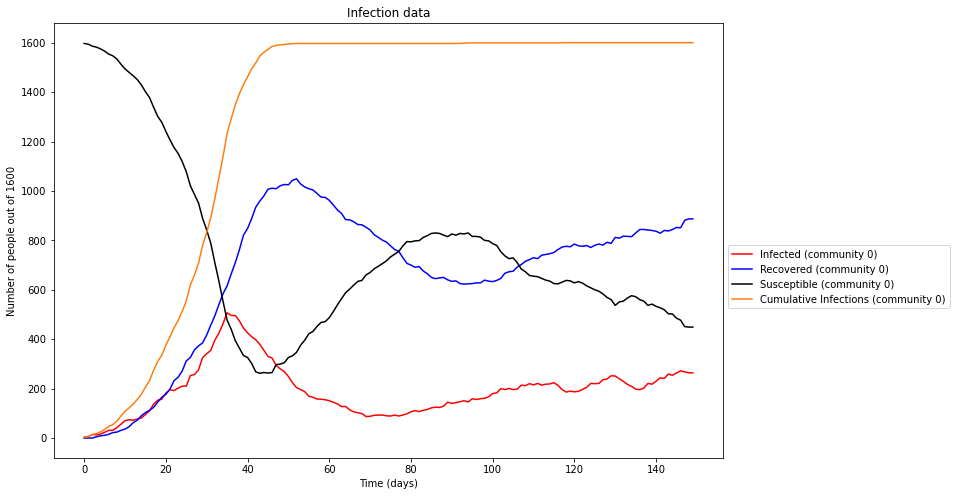

In [215]:
SIRS_grid_migration_nm(40, 40, 1, 1, T=150, plot=True, ret=False)

### Compare to continuous model

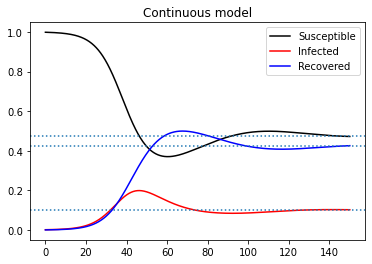

In [219]:
import scipy as sp
from scipy.integrate import odeint

def dPdt(u, t, beta, gamma, xi):
    s, i, r = u
    dsdt = -beta*i*s+xi*r
    didt = beta*i*s-gamma*i
    drdt = gamma*i-xi*r
    
    return dsdt, didt, drdt

def run_simulation(t=50, beta=0.3, gamma=1/7, xi=1/30):

    i0 = 0.001
    s0 = 1-i0
    r0 = 0.0
    u0 = s0, i0, r0

    t = np.linspace(0, t, 1000)
    sol = odeint(dPdt, u0, t, args = (beta, gamma, xi))
    s, i, r = sol[:, 0], sol[:, 1], sol[:, 2]
    
    plt.title(f"Continuous model")
    plt.plot(t, s, label="Susceptible", c="k")
    plt.plot(t, i, label="Infected", c="r")
    plt.plot(t, r, label="Recovered", c="b")
    
    # Fixed points (for i*>0) are given by
    s_fp = gamma/beta
    i_fp = (1-gamma/beta)/(1+gamma/xi)
    r_fp = (gamma/xi)*i_fp
    
    # Can check these are true numerically by plotting equil points as horizontal line
    plt.axhline(s_fp, ls=":")
    plt.axhline(i_fp, ls=":")
    plt.axhline(r_fp, ls=":")
    
    # # Characteristic time scale
    # tau = 1/(beta-gamma)
    # plt.axvline(tau, ls=":")

    plt.legend()
    plt.show()
    
run_simulation(t=150)

We see for relatively short time (before 'equillibrium' is reached) the continuous and discrete model match up (qualitatively) quite nicely

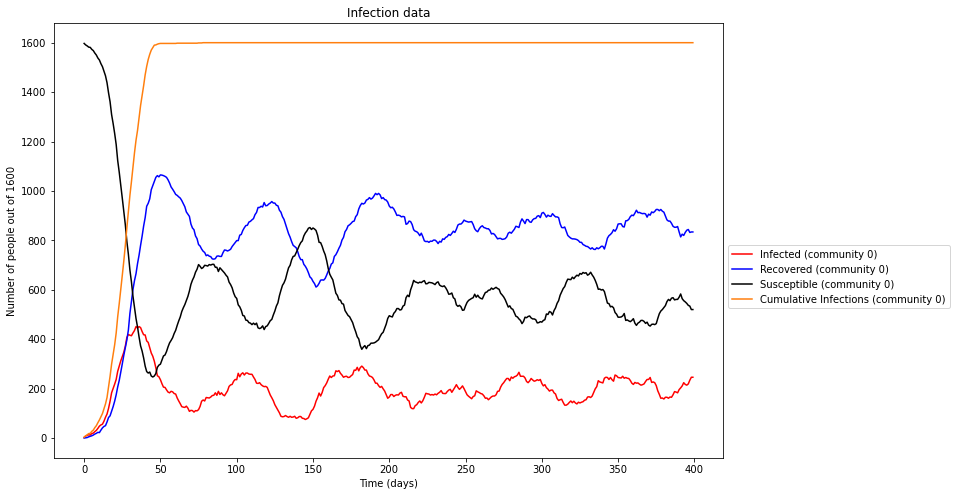

In [220]:
SIRS_grid_migration_nm(40, 40, 1, 1, T=400, plot=True, ret=False)

### Example of virus spread between communities in network

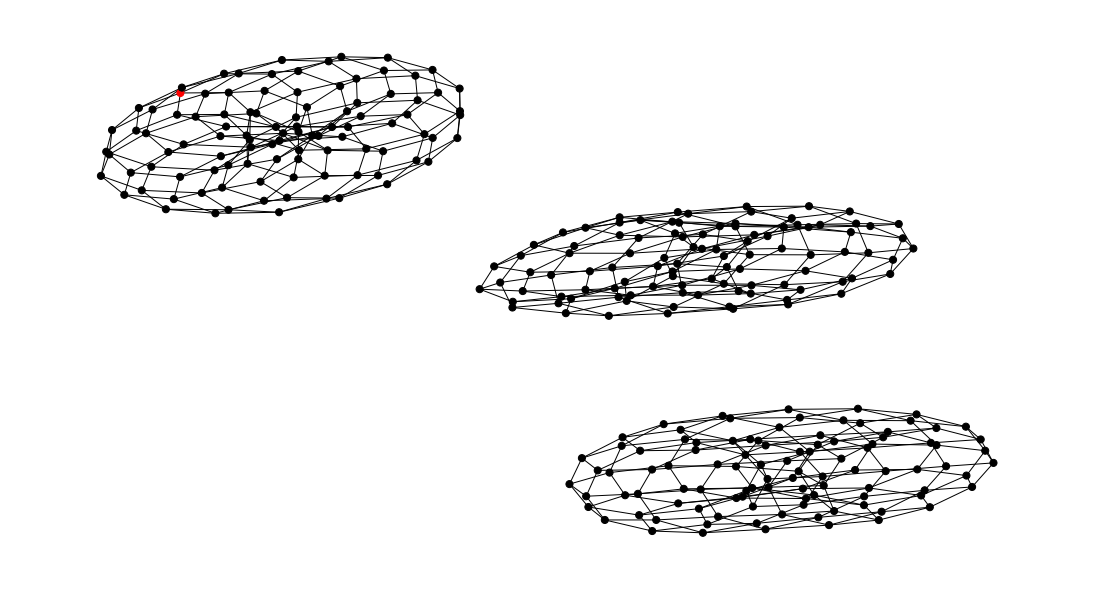

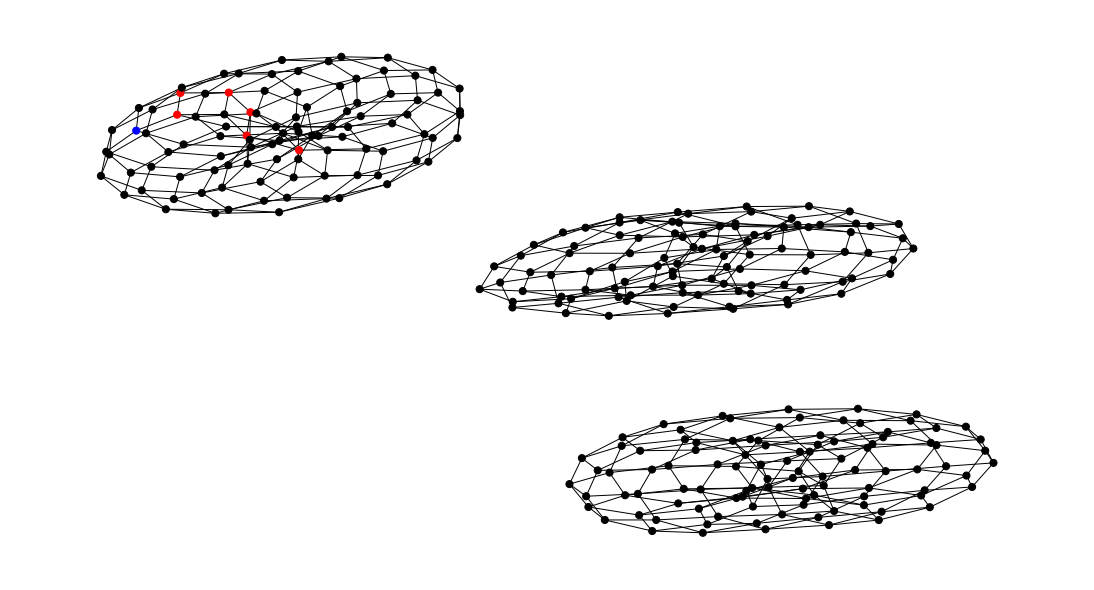

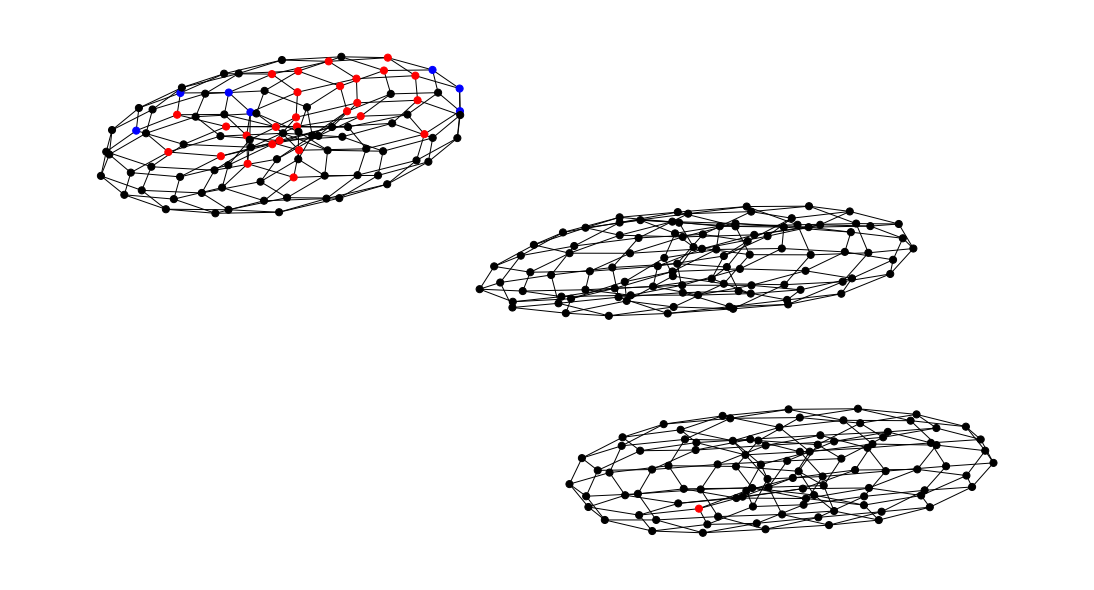

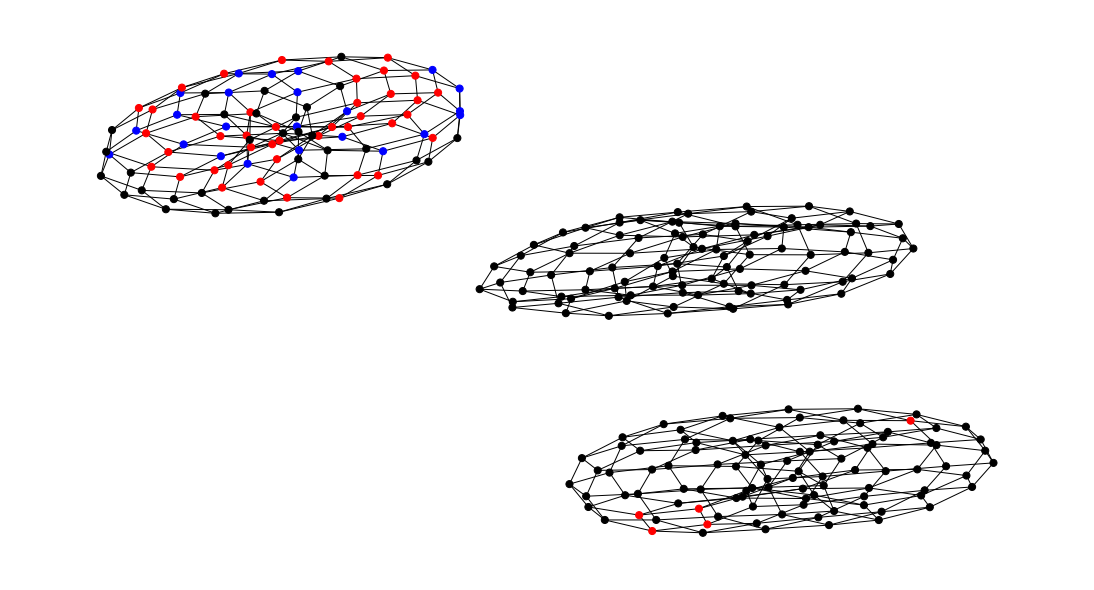

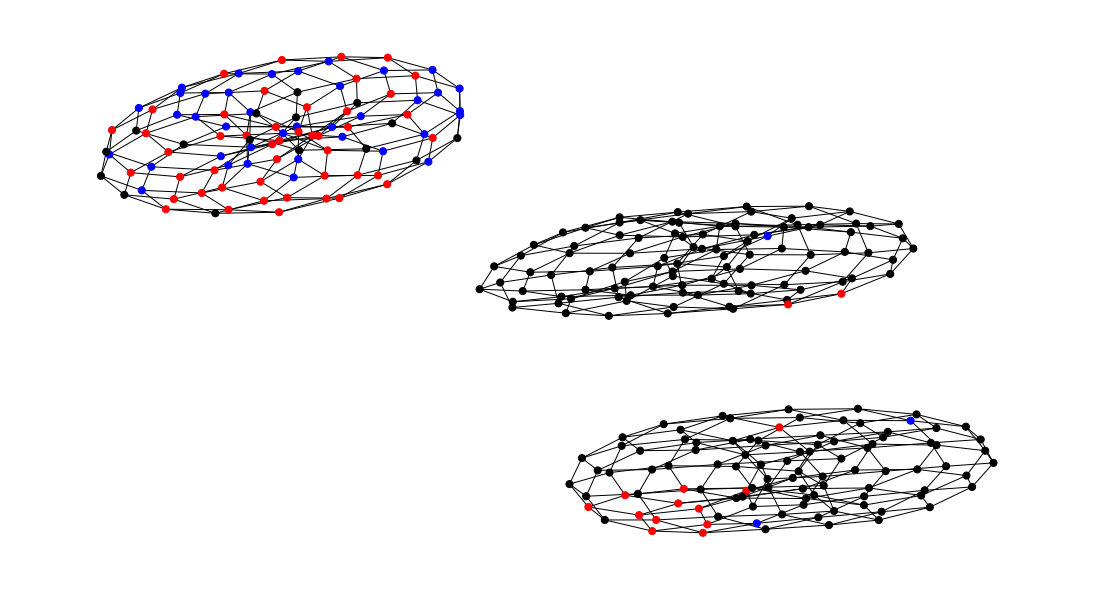

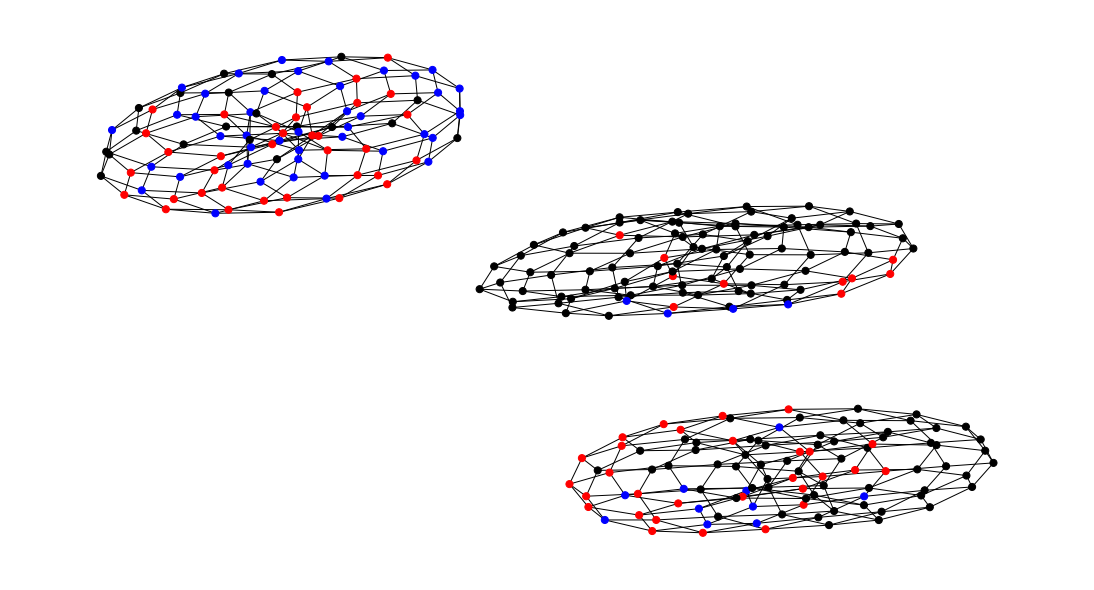

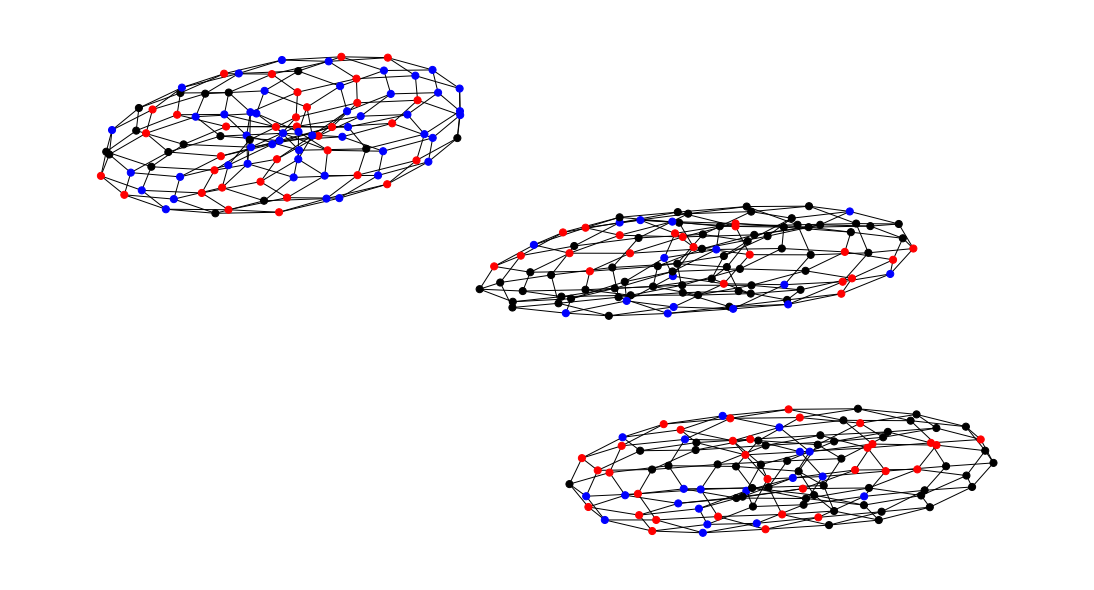

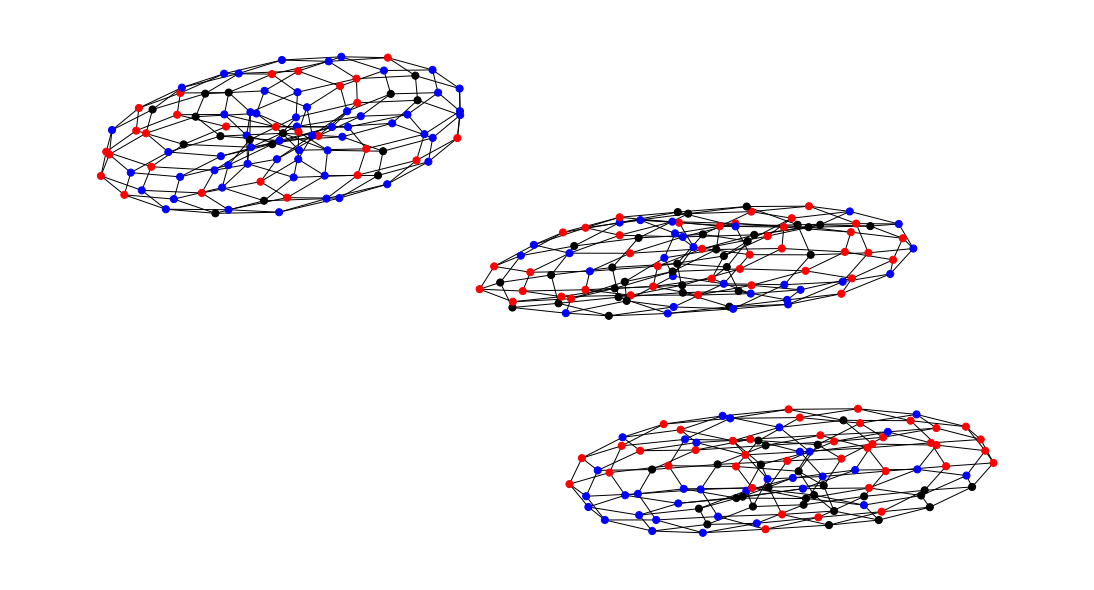

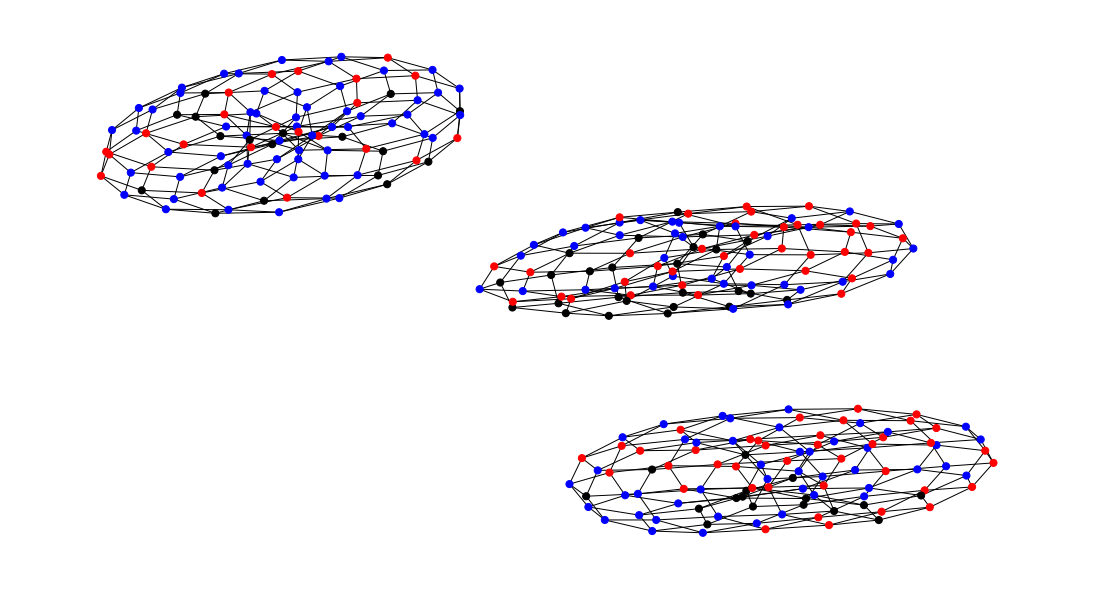

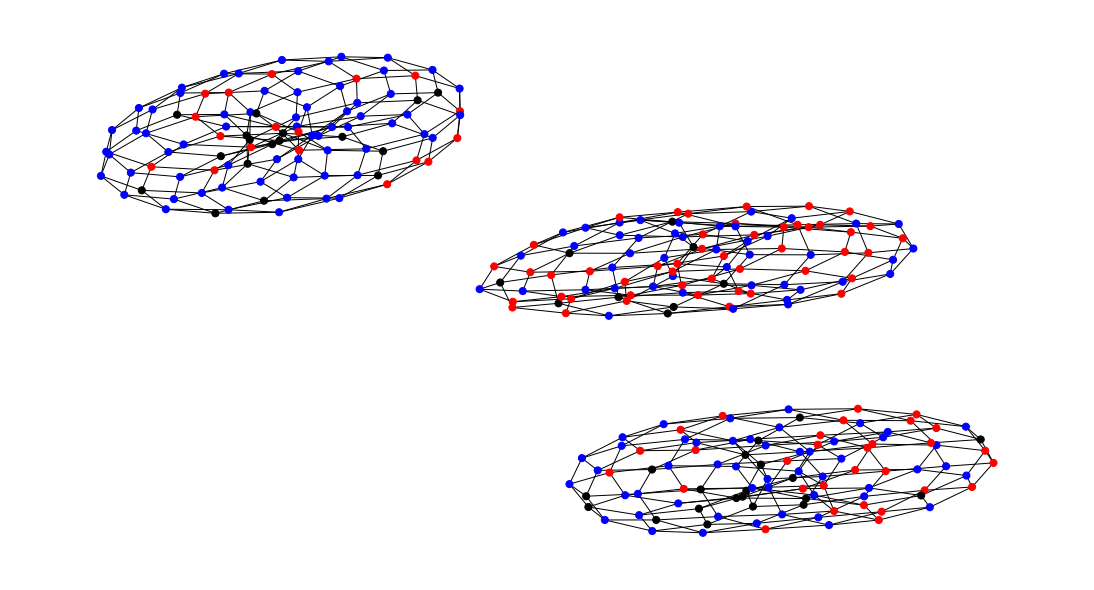

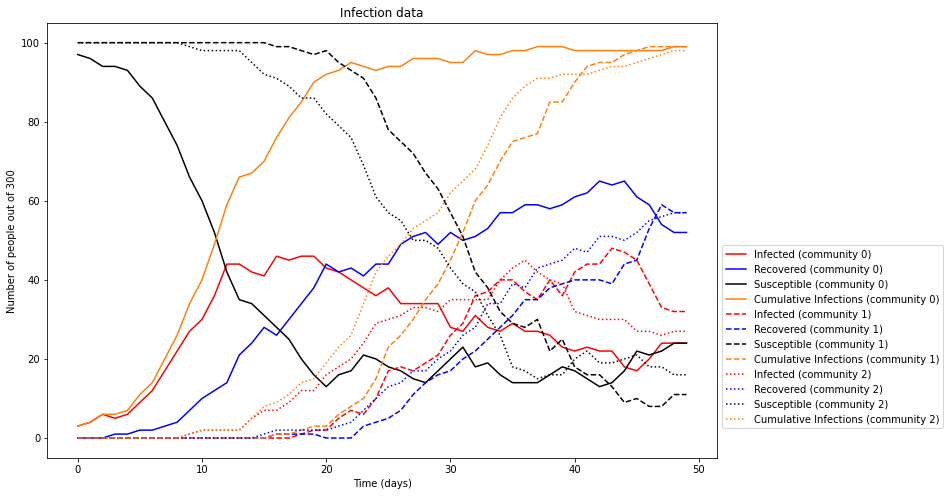

In [214]:
SIRS_grid_migration_nm(10, 10, 3, 1, T=50, p_i=0.15, p_r=0.1, plot=True, graph_every=5, ret=False)

### After initial transience, all communities settle around same equilibrium.

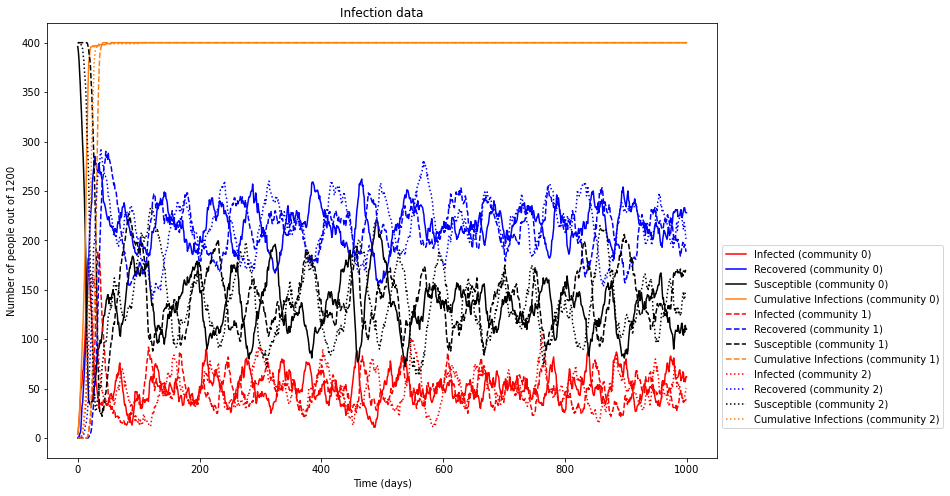

In [224]:
SIRS_grid_migration_nm(20, 20, 3, 1, T=1000, plot=True, ret=False)

# Data collection

### Results for one community

In [115]:
# get_stats single community

import os
from tqdm import tqdm

def get_stats(ps, num_iterations, filename, indep_var="p_i", save_file=False):
    N = len(ps)

    cum_infections_stats = np.zeros((N, 2))
    peak_infection_stats = np.zeros((N, 2))
    char_time_stats = np.zeros((N, 2))
    
    equil_num_susceptible_stats = np.zeros((N, 2))
    equil_num_infected_stats = np.zeros((N, 2))
    equil_num_recovered_stats = np.zeros((N, 2))

    for index, p in enumerate(tqdm(ps)):
        # Loop over each value of ps
        cum_infections = np.zeros(num_iterations)
        peak_infections = np.zeros(num_iterations)
        char_times = np.zeros(num_iterations)
        
        equil_num_susceptible = np.zeros(num_iterations)
        equil_num_infected = np.zeros(num_iterations)
        equil_num_recovered = np.zeros(num_iterations)
        
        for i in range(num_iterations):
            # Run simulation for p <num_iterations> times, and get statistics
            if indep_var == "p_i":
                result = SIRS_grid_migration_nm(20, 20, 1, 0.00, p_i=p)
            elif indep_var == "p_r":
                result = SIRS_grid_migration_nm(20, 20, 1, 0.00, p_r=p)
            elif indep_var == "p_w":
                result = SIRS_grid_migration_nm(20, 20, 1, 0.00, p_w=p)
            else:
                raise("Input indep_var=p_i or p_r or p_w")

                
            num_susceptible = result[0][0]
            num_infected = result[1][0]
            num_recovered = result[2][0]
            cum_infected = result[3][0]

                  
            cum_infections[i] = cum_infected[-1]
            peak_infections[i] = np.amax(num_infected)        
            
            char_times[i] = np.argmax(cum_infected > 0.36 * 20*20) if cum_infected[-1] > 0.36 * 20*20 else np.nan
            
            steady_state = (cum_infected == 20*20)
            if np.any(steady_state):
                equil_num_susceptible[i] = np.mean(num_susceptible[steady_state])
                equil_num_infected[i] = np.mean(num_infected[steady_state])
                equil_num_recovered[i] = np.mean(num_recovered[steady_state])
            else:
                equil_num_susceptible[i] = np.nan
                equil_num_infected[i] = np.nan
                equil_num_recovered[i] = np.nan

        # Get statistics (for current iteration) - save it to statistics arrays
        avg_cum_infections = np.mean(cum_infections)
        std_cum_infections = np.std(cum_infections)
        cum_infections_stats[index, 0], cum_infections_stats[index, 1] = avg_cum_infections, std_cum_infections
        
        avg_peak_infections = np.mean(peak_infections)
        std_peak_infections = np.std(peak_infections)
        peak_infection_stats[index, 0], peak_infection_stats[index, 1] = avg_peak_infections, std_peak_infections
        
        avg_char_time = np.nanmean(char_times)
        std_char_time = np.nanstd(char_times)
        char_time_stats[index, 0], char_time_stats[index, 1] = avg_char_time, std_char_time
                
        avg_equil_susceptible = np.nanmean(equil_num_susceptible)
        std_equil_susceptible = np.nanstd(equil_num_susceptible)
        equil_num_susceptible_stats[index, 0], equil_num_susceptible_stats[index, 1] = avg_equil_susceptible, std_equil_susceptible
        
        avg_equil_infected = np.nanmean(equil_num_infected)
        std_equil_infected = np.nanstd(equil_num_infected)
        equil_num_infected_stats[index, 0], equil_num_infected_stats[index, 1] = avg_equil_infected, std_equil_infected

        avg_equil_recovered = np.nanmean(equil_num_recovered)
        std_equil_recovered = np.nanstd(equil_num_recovered)
        equil_num_recovered_stats[index, 0], equil_num_recovered_stats[index, 1] = avg_equil_recovered, std_equil_recovered
    
    if save_file:
        ## This is how I saved my files originally, this has been disabled for the final version
        # Saving the data
        dir = os.getcwd()
        data_folder = "Q3_SIRS_model\\project_data"
        save_loc = os.path.join(dir, data_folder, filename)
        
        # Save the data as numpy array at "save_loc"
        np.savez(save_loc, ps=ps, cum_infections_stats=cum_infections_stats, peak_infection_stats=peak_infection_stats, char_time_stats=char_time_stats, 
                equil_num_susceptible_stats=equil_num_susceptible_stats, equil_num_infected_stats=equil_num_infected_stats,
                equil_num_recovered_stats=equil_num_recovered_stats)
    
    return ps, cum_infections_stats, peak_infection_stats, char_time_stats, equil_num_susceptible_stats, equil_num_infected_stats, equil_num_recovered_stats


In [589]:
# One community simulation
num_sims = 200
# num_pvals = 10

ps = np.append(np.array([0.01, 0.03, 0.05, 0.08]), np.linspace(0.1, 1.0, num=10))

pis = ps
results_pi = get_stats(pis, num_sims, "grid_pi_1community_round3.npz", indep_var="p_i", save_file=False)

prs = ps
results_pr = get_stats(prs, num_sims, "grid_pr_1community_round3.npz", indep_var="p_r", save_file=False)

pws = ps
results_pw = get_stats(pis, num_sims, "grid_pw_1community_round3.npz", indep_var="p_w", save_file=False)

  0%|          | 0/14 [00:00<?, ?it/s]C:\Users\jmonc\AppData\Local\Temp\ipykernel_18780\3588719986.py:69: RuntimeWarning: Mean of empty slice
  avg_char_time = np.nanmean(char_times)
c:\Users\jmonc\anaconda3\envs\cplxsys\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\jmonc\AppData\Local\Temp\ipykernel_18780\3588719986.py:73: RuntimeWarning: Mean of empty slice
  avg_equil_susceptible = np.nanmean(equil_num_susceptible)
C:\Users\jmonc\AppData\Local\Temp\ipykernel_18780\3588719986.py:77: RuntimeWarning: Mean of empty slice
  avg_equil_infected = np.nanmean(equil_num_infected)
C:\Users\jmonc\AppData\Local\Temp\ipykernel_18780\3588719986.py:81: RuntimeWarning: Mean of empty slice
  avg_equil_recovered = np.nanmean(equil_num_recovered)
100%|██████████| 14/14 [1:20:40<00:00, 345.76s/it]


In [606]:
# Collecting data from get_stats

ps = results_pi[0]

avg_cum_infections_pi = results_pi[1][:,0]
std_cum_infections_pi = results_pi[1][:, 1]

avg_peak_infection_number_pi = results_pi[2][:, 0]
std_peak_infection_number_pi = results_pi[2][:, 1]

avg_char_time_pi = results_pi[3][:, 0]
std_char_time_pi = results_pi[3][:, 1]


avg_equil_infected_pi = results_pi[5][:, 0]
std_equil_infected_pi = results_pi[5][:, 1]

avg_equil_recovered_pi = results_pi[6][:, 0]
std_equil_recovered_pi = results_pi[6][:, 1]

avg_equil_susceptible_pi = results_pi[4][:, 0]
std_equil_susceptible_pi = results_pi[4][:, 1]

pr = results_pr[0]

avg_cum_infections_pr = results_pr[1][:, 0]
std_cum_infections_pr = results_pr[1][:, 1]

avg_peak_infection_number_pr = results_pr[2][:, 0]
std_peak_infection_number_pr = results_pr[2][:, 1]

avg_char_time_pr = results_pr[3][:, 0]
std_char_time_pr = results_pr[3][:, 1]


avg_equil_infected_pr = results_pr[5][:, 0]
std_equil_infected_pr = results_pr[5][:, 1]

avg_equil_recovered_pr = results_pr[6][:, 0]
std_equil_recovered_pr = results_pr[6][:, 1]

avg_equil_susceptible_pr = results_pr[4][:, 0]
std_equil_susceptible_pr = results_pr[4][:, 1]

pw = results_pw[0]

avg_cum_infections_pw = results_pw[1][:, 0]
std_cum_infections_pw = results_pw[1][:, 1]

avg_peak_infection_number_pw = results_pw[2][:, 0]
std_peak_infection_number_pw = results_pw[2][:, 1]

avg_char_time_pw = results_pw[3][:, 0]
std_char_time_pw = results_pw[3][:, 1]


avg_equil_infected_pw = results_pw[5][:, 0]
std_equil_infected_pw = results_pw[5][:, 1]

avg_equil_recovered_pw = results_pw[6][:, 0]
std_equil_recovered_pw = results_pw[6][:, 1]

avg_equil_susceptible_pw = results_pw[4][:, 0]
std_equil_susceptible_pw = results_pw[4][:, 1]

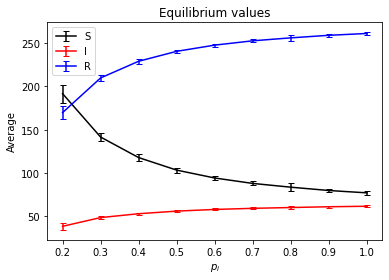

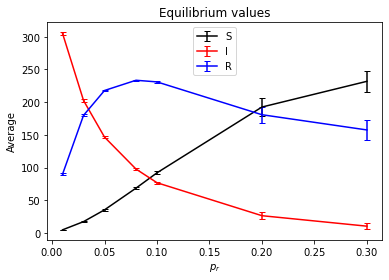

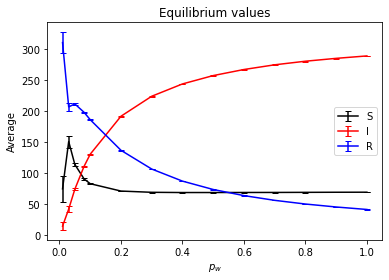

In [607]:
# Plotting data for 1 community
plt.errorbar(ps, avg_equil_susceptible_pi, yerr=std_equil_susceptible_pi, c="k", label="S", capsize=3)
plt.errorbar(ps, avg_equil_infected_pi, yerr=std_equil_infected_pi, c="r", label="I", capsize=3)
plt.errorbar(ps, avg_equil_recovered_pi, yerr=std_equil_recovered_pi, c="b", label="R", capsize=3)

plt.legend()
plt.xlabel("$p_i$")
plt.ylabel("Average")
plt.title("Equilibrium values")
plt.show()

plt.errorbar(pr, avg_equil_susceptible_pr, yerr=std_equil_susceptible_pr, c="k", label="S", capsize=3)
plt.errorbar(pr, avg_equil_infected_pr, yerr=std_equil_infected_pr, c="r", label="I", capsize=3)
plt.errorbar(pr, avg_equil_recovered_pr, yerr=std_equil_recovered_pr, c="b", label="R", capsize=3)

plt.legend()
plt.xlabel("$p_r$")
plt.ylabel("Average")
plt.title("Equilibrium values")
plt.show()

plt.errorbar(pw, avg_equil_susceptible_pw, yerr=std_equil_susceptible_pw, c="k", label="S", capsize=3)
plt.errorbar(pw, avg_equil_infected_pw, yerr=std_equil_infected_pw, c="r", label="I", capsize=3)
plt.errorbar(pw, avg_equil_recovered_pw, yerr=std_equil_recovered_pw, c="b", label="R", capsize=3)

plt.legend()
plt.xlabel("$p_w$")
plt.ylabel("Average")
plt.title("Equilibrium values")
plt.show()

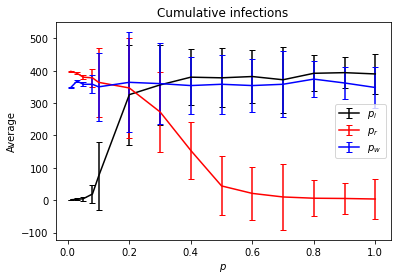

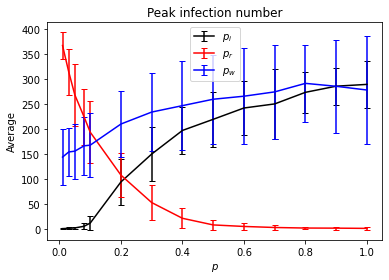

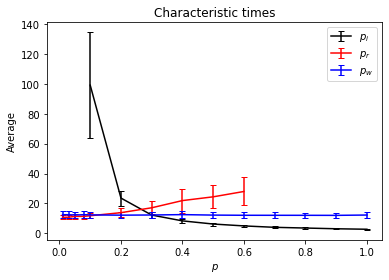

In [608]:
# (2) Plotting data for 1 community
plt.errorbar(ps, avg_cum_infections_pi, yerr=std_cum_infections_pi, c="k", label="$p_i$", capsize=3)
plt.errorbar(pr, avg_cum_infections_pr, yerr=std_cum_infections_pi, c="r", label="$p_r$", capsize=3)
plt.errorbar(pw, avg_cum_infections_pw, yerr=std_cum_infections_pi, c="b", label="$p_w$", capsize=3)

plt.legend()
plt.xlabel("$p$")
plt.ylabel("Average")
plt.title("Cumulative infections")
plt.show()

plt.errorbar(ps, avg_peak_infection_number_pi, yerr=std_peak_infection_number_pi, c="k", label="$p_i$", capsize=3)
plt.errorbar(pr, avg_peak_infection_number_pr, yerr=std_peak_infection_number_pr, c="r", label="$p_r$", capsize=3)
plt.errorbar(pw, avg_peak_infection_number_pw, yerr=std_peak_infection_number_pw, c="b", label="$p_w$", capsize=3)

plt.legend()
plt.xlabel("$p$")
plt.ylabel("Average")
plt.title("Peak infection number")
plt.show()

plt.errorbar(ps, avg_char_time_pi, yerr=std_char_time_pi, c="k", label="$p_i$", capsize=3)
plt.errorbar(pr, avg_char_time_pr, yerr=std_char_time_pr, c="r", label="$p_r$", capsize=3)
plt.errorbar(pw, avg_char_time_pw, yerr=std_char_time_pw, c="b", label="$p_w$", capsize=3)

plt.legend()
plt.xlabel("$p$")
plt.ylabel("Average")
plt.title("Characteristic times")
plt.show()

### Results for four communities

In [609]:
def get_stats_community(n, m, num_communities, migration_rate, ps, num_iterations, filename, indep_var="p_i"):
    N = len(ps)

    # Individual community stats
    first_infection_times_stats = np.zeros((N, num_communities, 2))
    
    # Whole population stats
    cum_infections_stats = np.zeros((N, 2))
    peak_infection_stats = np.zeros((N, 2))
    char_time_stats = np.zeros((N, 2))
    
    equil_num_susceptible_stats = np.zeros((N, 2))
    equil_num_infected_stats = np.zeros((N, 2))
    equil_num_recovered_stats = np.zeros((N, 2))

    for index, p in enumerate(tqdm(ps)):
        # Loop over each value of ps
        first_infection_times = np.zeros((num_iterations, num_communities))
        
        peak_infections = np.zeros(num_iterations)
        cum_infections = np.zeros(num_iterations)
        char_times = np.zeros(num_iterations)
        
        equil_num_susceptible = np.zeros(num_iterations)
        equil_num_infected = np.zeros(num_iterations)
        equil_num_recovered = np.zeros(num_iterations)
        
        for i in range(num_iterations):
            # Run simulation for p <num_iterations> times, and get statistics
            if indep_var == "p_i":
                result = SIRS_grid_migration_nm(n, m, num_communities, migration_rate, p_i=p)
            elif indep_var == "p_r":
                result = SIRS_grid_migration_nm(n, m, num_communities, migration_rate, p_r=p)
            elif indep_var == "p_w":
                result = SIRS_grid_migration_nm(n, m, num_communities, migration_rate, p_w=p)
            elif indep_var == "migration_rate":
                result = SIRS_grid_migration_nm(n, m, num_communities, p)

            # Data for each community
            num_susceptible = result[0]
            num_infected = result[1]
            num_recovered = result[2]
            cum_infected = result[3]
            
            # Determine times that each new community is infected
            community_infection_times = np.zeros(num_communities)
            for k in range(num_communities):
                time = np.argmax(num_infected[k] >= 1) if np.any(num_infected[k] >= 1) else np.nan
                community_infection_times[k] = time
            first_infection_times[i, :] = np.sort(community_infection_times)
            
            # Data for all communities combined
            num_susceptible_all = np.sum(num_susceptible, axis=0)
            num_infected_all = np.sum(num_infected, axis=0)
            num_recovered_all = np.sum(num_recovered, axis=0)
            cum_infected_all = np.sum(cum_infected, axis=0)
            
            peak_infections[i] = np.amax(num_infected_all)
                        
            cum_infections[i] = cum_infected_all[-1]
            char_times[i] = np.argmax(cum_infected_all > 0.36 * n*m*num_communities) if cum_infected_all[-1] > 0.36 * n*m*num_communities else np.nan
            
            steady_state = (cum_infected_all == n*m*num_communities)
            if np.any(steady_state):
                equil_num_susceptible[i] = np.mean(num_susceptible_all[steady_state])
                equil_num_infected[i] = np.mean(num_infected_all[steady_state])
                equil_num_recovered[i] = np.mean(num_recovered_all[steady_state])
            else:
                equil_num_susceptible[i] = np.nan
                equil_num_infected[i] = np.nan
                equil_num_recovered[i] = np.nan

        # Get statistics
        avg_first_infection_times = np.nanmean(first_infection_times, axis=0)
        std_first_infection_times = np.nanstd(first_infection_times, axis=0)
        first_infection_times_stats[index, :, 0], first_infection_times_stats[index, :, 1] = avg_first_infection_times, std_first_infection_times
        
        
        avg_peak_infections = np.mean(peak_infections)
        std_peak_infections = np.std(peak_infections)
        peak_infection_stats[index, 0], peak_infection_stats[index, 1] = avg_peak_infections, std_peak_infections
        
        avg_cum_infections = np.mean(cum_infections)
        std_cum_infections = np.std(cum_infections)
        cum_infections_stats[index, 0], cum_infections_stats[index, 1] = avg_cum_infections, std_cum_infections
        
        avg_char_time = np.nanmean(char_times)
        std_char_time = np.nanstd(char_times)
        char_time_stats[index, 0], char_time_stats[index, 1] = avg_char_time, std_char_time
        
        avg_equil_susceptible = np.nanmean(equil_num_susceptible)
        std_equil_susceptible = np.nanstd(equil_num_susceptible)
        equil_num_susceptible_stats[index, 0], equil_num_susceptible_stats[index, 1] = avg_equil_susceptible, std_equil_susceptible
        
        avg_equil_infected = np.nanmean(equil_num_infected)
        std_equil_infected = np.nanstd(equil_num_infected)
        equil_num_infected_stats[index, 0], equil_num_infected_stats[index, 1] = avg_equil_infected, std_equil_infected

        avg_equil_recovered = np.nanmean(equil_num_recovered)
        std_equil_recovered = np.nanstd(equil_num_recovered)
        equil_num_recovered_stats[index, 0], equil_num_recovered_stats[index, 1] = avg_equil_recovered, std_equil_recovered

    # Again, if you wanted to save data to a file you could uncomment this
    # # Saving the data
    # dir = os.getcwd()
    # # data_folder = "project_data"
    # # save_loc = os.path.join(dir, data_folder, filename)
    # save_loc = os.path.join(dir, filename)
    
    # # Save the data as numpy array at "save_loc"
    # np.savez(save_loc, ps=ps, cum_infections_stats=cum_infections_stats, char_time_stats=char_time_stats, peak_infection_stats=peak_infection_stats,
    #          equil_num_susceptible_stats=equil_num_susceptible_stats, equil_num_infected_stats=equil_num_infected_stats,
    #          equil_num_recovered_stats=equil_num_recovered_stats, first_infection_times_stats=first_infection_times_stats)
    
    return ps, cum_infections_stats, peak_infection_stats, char_time_stats, equil_num_susceptible_stats, equil_num_infected_stats, equil_num_recovered_stats, first_infection_times_stats


In [610]:
# Run simulations

num_sims = 120

ps = np.append(np.array([0.01, 0.03, 0.05, 0.08]), np.linspace(0.1, 1.0, num=10))


pis = ps
results_pi_4com = get_stats_community(10, 10, 4, 1.0, pis, num_sims, "grid_pi_4_community_c.npz", indep_var="p_i")

prs = ps
results_pr_4com = get_stats_community(10, 10, 4, 1.0, prs, num_sims, "grid_pr_4_community_c.npz", indep_var="p_r")

pws = ps
results_pw_4com = get_stats_community(10, 10, 4, 1.0, pws, num_sims, "grid_pw_4_community_c.npz", indep_var="p_w")

mrs = np.linspace(0.0, 1.0, num=10)
results_mr_4com = get_stats_community(10, 10, 4, 1.0, mrs, num_sims, "grid_mr_4_community_c.npz", indep_var="migration_rate")

  0%|          | 0/14 [00:00<?, ?it/s]C:\Users\jmonc\AppData\Local\Temp\ipykernel_18780\3132429753.py:74: RuntimeWarning: Mean of empty slice
  avg_first_infection_times = np.nanmean(first_infection_times, axis=0)
C:\Users\jmonc\AppData\Local\Temp\ipykernel_18780\3132429753.py:87: RuntimeWarning: Mean of empty slice
  avg_char_time = np.nanmean(char_times)
C:\Users\jmonc\AppData\Local\Temp\ipykernel_18780\3132429753.py:91: RuntimeWarning: Mean of empty slice
  avg_equil_susceptible = np.nanmean(equil_num_susceptible)
C:\Users\jmonc\AppData\Local\Temp\ipykernel_18780\3132429753.py:95: RuntimeWarning: Mean of empty slice
  avg_equil_infected = np.nanmean(equil_num_infected)
C:\Users\jmonc\AppData\Local\Temp\ipykernel_18780\3132429753.py:99: RuntimeWarning: Mean of empty slice
  avg_equil_recovered = np.nanmean(equil_num_recovered)
100%|██████████| 10/10 [35:29<00:00, 212.96s/it]


In [611]:
# Return results

pi = results_pi_4com[0]

avg_cum_infections_pi = results_pi_4com[1][:,0]
std_cum_infections_pi = results_pi_4com[1][:, 1]

avg_peak_infection_number_pi = results_pi_4com[2][:, 0]
std_peak_infection_number_pi = results_pi_4com[2][:, 1]

avg_char_time_pi = results_pi_4com[3][:, 0]
std_char_time_pi = results_pi_4com[3][:, 1]


avg_equil_infected_pi = results_pi_4com[5][:, 0]
std_equil_infected_pi = results_pi_4com[5][:, 1]

avg_equil_recovered_pi = results_pi_4com[6][:, 0]
std_equil_recovered_pi = results_pi_4com[6][:, 1]

avg_equil_susceptible_pi = results_pi_4com[4][:, 0]
std_equil_susceptible_pi = results_pi_4com[4][:, 1]

pr = results_pr_4com[0]

avg_cum_infections_pr = results_pr_4com[1][:, 0]
std_cum_infections_pr = results_pr_4com[1][:, 1]

avg_peak_infection_number_pr = results_pr_4com[2][:, 0]
std_peak_infection_number_pr = results_pr_4com[2][:, 1]

avg_char_time_pr = results_pr_4com[3][:, 0]
std_char_time_pr = results_pr_4com[3][:, 1]


avg_equil_infected_pr = results_pr_4com[5][:, 0]
std_equil_infected_pr = results_pr_4com[5][:, 1]

avg_equil_recovered_pr = results_pr_4com[6][:, 0]
std_equil_recovered_pr = results_pr_4com[6][:, 1]

avg_equil_susceptible_pr = results_pr_4com[4][:, 0]
std_equil_susceptible_pr = results_pr_4com[4][:, 1]

pw = results_pw_4com[0]

avg_cum_infections_pw = results_pw_4com[1][:, 0]
std_cum_infections_pw = results_pw_4com[1][:, 1]

avg_peak_infection_number_pw = results_pw_4com[2][:, 0]
std_peak_infection_number_pw = results_pw_4com[2][:, 1]

avg_char_time_pw = results_pw_4com[3][:, 0]
std_char_time_pw = results_pw_4com[3][:, 1]


avg_equil_infected_pw = results_pw_4com[5][:, 0]
std_equil_infected_pw = results_pw_4com[5][:, 1]

avg_equil_recovered_pw = results_pw_4com[6][:, 0]
std_equil_recovered_pw = results_pw_4com[6][:, 1]

avg_equil_susceptible_pw = results_pw_4com[4][:, 0]
std_equil_susceptible_pw = results_pw_4com[4][:, 1]

mr = results_mr_4com[0]

avg_cum_infections_mr = results_mr_4com[1][:,0]
std_cum_infections_mr = results_mr_4com[1][:, 1]

avg_peak_infection_number_mr = results_mr_4com[2][:, 0]
std_peak_infection_number_mr = results_mr_4com[2][:, 1]

avg_char_time_mr = results_mr_4com[3][:, 0]
std_char_time_mr = results_mr_4com[3][:, 1]


avg_equil_infected_mr = results_mr_4com[5][:, 0]
std_equil_infected_mr = results_mr_4com[5][:, 1]

avg_equil_recovered_mr = results_mr_4com[6][:, 0]
std_equil_recovered_mr = results_mr_4com[6][:, 1]

avg_equil_susceptible_mr = results_mr_4com[4][:, 0]
std_equil_susceptible_mr = results_mr_4com[4][:, 1]


avg_first_infection_times_pi = results_pi_4com[-1][:, 0]
std_first_infection_times_pi = results_pi_4com[-1][:, 1]

avg_first_infection_times_pr = results_pr_4com[-1][:, 0]
std_first_infection_times_pr = results_pr_4com[-1][:, 1]

avg_first_infection_times_pw = results_pw_4com[-1][:, 0]
std_first_infection_times_pw = results_pw_4com[-1][:, 1]

avg_first_infection_times_mr = results_mr_4com[-1][:, 0]
std_first_infection_times_mr = results_mr_4com[-1][:, 1]

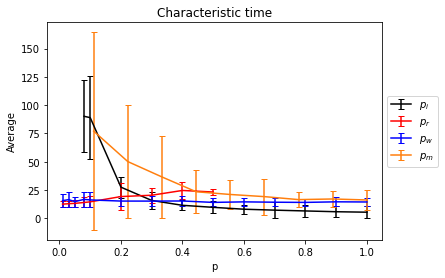

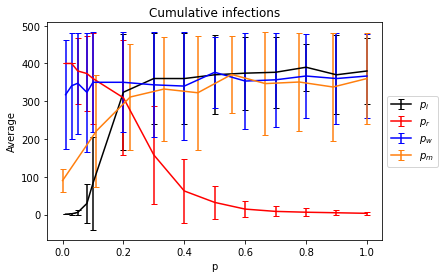

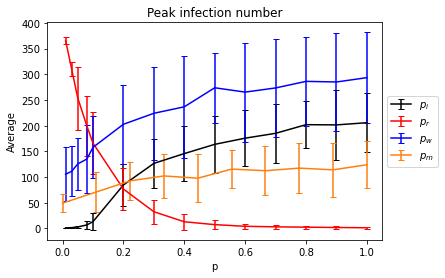

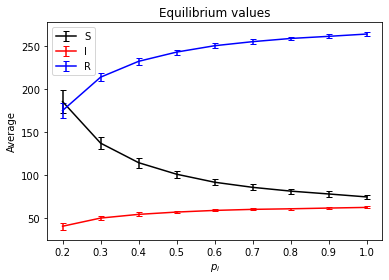

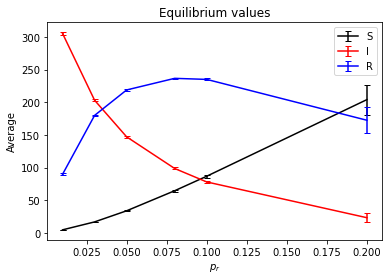

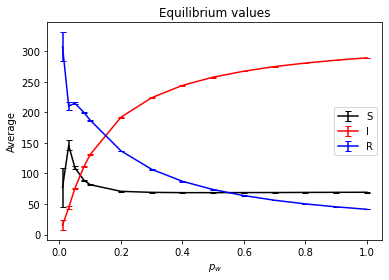

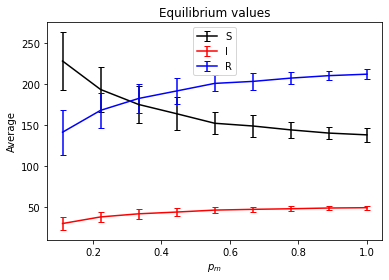

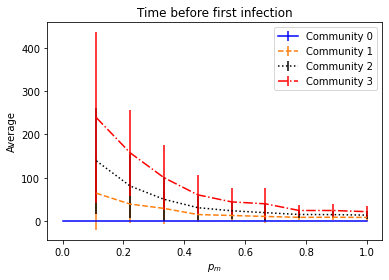

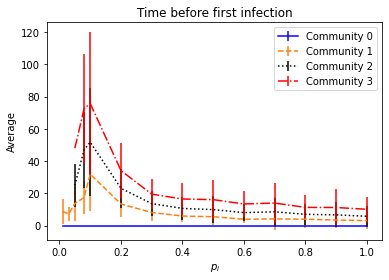

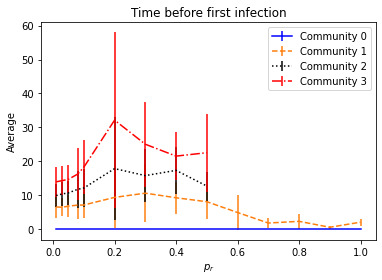

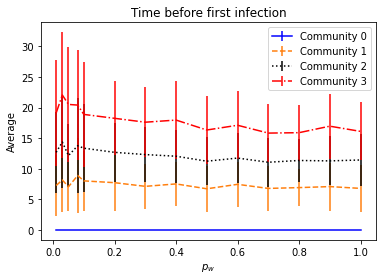

In [612]:
# Plot results

plt.errorbar(pi, avg_char_time_pi, yerr=std_char_time_pi, c="k", capsize=3, label="$p_i$")
plt.errorbar(pr, avg_char_time_pr, yerr=std_char_time_pr, c="r", capsize=3, label="$p_r$")
plt.errorbar(pw, avg_char_time_pw, yerr=std_char_time_pw, c="b", capsize=3, label="$p_w$")
plt.errorbar(mr, avg_char_time_mr, yerr=std_char_time_mr, c="C1", capsize=3, label="$p_m$")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Characteristic time")
plt.xlabel("p")
plt.ylabel("Average")
plt.show()


plt.errorbar(pi, avg_cum_infections_pi, yerr=std_cum_infections_pi, c="k", capsize=3, label="$p_i$")
plt.errorbar(pr, avg_cum_infections_pr, yerr=std_cum_infections_pr, c="r", capsize=3, label="$p_r$")
plt.errorbar(pw, avg_cum_infections_pw, yerr=std_cum_infections_pw, c="b", capsize=3, label="$p_w$")
plt.errorbar(mr, avg_cum_infections_mr, yerr=std_cum_infections_mr, c="C1", capsize=3, label="$p_m$")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Cumulative infections")
plt.xlabel("p")
plt.ylabel("Average")
plt.show()


plt.errorbar(pi, avg_peak_infection_number_pi, yerr=std_peak_infection_number_pi, c="k", capsize=3, label="$p_i$")
plt.errorbar(pr, avg_peak_infection_number_pr, yerr=std_peak_infection_number_pr, c="r", capsize=3, label="$p_r$")
plt.errorbar(pw, avg_peak_infection_number_pw, yerr=std_peak_infection_number_pw, c="b", capsize=3, label="$p_w$")
plt.errorbar(mr, avg_peak_infection_number_mr, yerr=std_peak_infection_number_mr, c="C1", capsize=3, label="$p_m$")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Peak infection number")
plt.xlabel("p")
plt.ylabel("Average")
plt.show()


# Plotting data for 1 community
plt.errorbar(pi, avg_equil_susceptible_pi, yerr=std_equil_susceptible_pi, c="k", label="S", capsize=3)
plt.errorbar(pi, avg_equil_infected_pi, yerr=std_equil_infected_pi, c="r", label="I", capsize=3)
plt.errorbar(pi, avg_equil_recovered_pi, yerr=std_equil_recovered_pi, c="b", label="R", capsize=3)

plt.legend()
plt.xlabel("$p_i$")
plt.ylabel("Average")
plt.title("Equilibrium values")
plt.show()

plt.errorbar(pr, avg_equil_susceptible_pr, yerr=std_equil_susceptible_pr, c="k", label="S", capsize=3)
plt.errorbar(pr, avg_equil_infected_pr, yerr=std_equil_infected_pr, c="r", label="I", capsize=3)
plt.errorbar(pr, avg_equil_recovered_pr, yerr=std_equil_recovered_pr, c="b", label="R", capsize=3)

plt.legend()
plt.xlabel("$p_r$")
plt.ylabel("Average")
plt.title("Equilibrium values")
plt.show()

plt.errorbar(pw, avg_equil_susceptible_pw, yerr=std_equil_susceptible_pw, c="k", label="S", capsize=3)
plt.errorbar(pw, avg_equil_infected_pw, yerr=std_equil_infected_pw, c="r", label="I", capsize=3)
plt.errorbar(pw, avg_equil_recovered_pw, yerr=std_equil_recovered_pw, c="b", label="R", capsize=3)

plt.legend()
plt.xlabel("$p_w$")
plt.ylabel("Average")
plt.title("Equilibrium values")
plt.show()


plt.errorbar(mr, avg_equil_susceptible_mr, yerr=std_equil_susceptible_mr, c="k", label="S", capsize=3)
plt.errorbar(mr, avg_equil_infected_mr, yerr=std_equil_infected_mr, c="r", label="I", capsize=3)
plt.errorbar(mr, avg_equil_recovered_mr, yerr=std_equil_recovered_mr, c="b", label="R", capsize=3)

plt.legend()
plt.xlabel("$p_m$")
plt.ylabel("Average")
plt.title("Equilibrium values")
plt.show()



def plot_community_infection_time(datum="mr"):
    """Helper method to plot community infection time for each community"""
    linestyles = ["solid", "dashed", "dotted", "dashdot"]
    colours = ["b", "C1", "k", "r"]
    for k in range(4):
        # plt.errorbar(ps, avg_first_infection_times_mr[:, k], yerr=std_first_infection_times_mr[:, k], c=colours[k%4],
        #                 capsize=3, ls=linestyles[k%4], label=f"Community {k}")
        if datum == "mr":
            ps = results_mr_4com[0]
            avg = results_mr_4com[-1][:, k, 0]
            std = results_mr_4com[-1][:, k, 1]
            xlabel="$p_m$"
        elif datum == "pi":
            ps = results_pi_4com[0]
            avg = results_pi_4com[-1][:, k, 0]
            std = results_pi_4com[-1][:, k, 1]
            xlabel="$p_i$"
        elif datum == "pw":
            ps = results_pw_4com[0]
            avg = results_pw_4com[-1][:, k, 0]
            std = results_pw_4com[-1][:, k, 1]
            xlabel="$p_w$"
        elif datum == "pr":
            ps = results_pr_4com[0]
            avg = results_pr_4com[-1][:, k, 0]
            std = results_pr_4com[-1][:, k, 1]
            xlabel="$p_r$"
        plt.errorbar(ps, avg, yerr=std, c=colours[k%4], ls=linestyles[k%4], label=f"Community {k}")
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel("Average")
    plt.title("Time before first infection")
    plt.show()
    
plot_community_infection_time(datum="mr")
plot_community_infection_time(datum="pi")
plot_community_infection_time(datum="pr")
plot_community_infection_time(datum="pw")



